In [1]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

/Users/blyo/Documents/research/thesis-lab/LyoSavin2023
['/Users/blyo/Documents/research/thesis-lab/LyoSavin2023/demos', '/opt/homebrew/Caskroom/miniforge/base/envs/pyenv311_mps/lib/python311.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/pyenv311_mps/lib/python3.11', '/opt/homebrew/Caskroom/miniforge/base/envs/pyenv311_mps/lib/python3.11/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/pyenv311_mps/lib/python3.11/site-packages', '/Users/blyo/Documents/research/thesis-lab/LyoSavin2023/core', '/Users/blyo/Documents/research/thesis-lab/LyoSavin2023/core/utils']


In [174]:
from utils import select_model
from prior_utils import p_sample_loop

MODEL_NAME = 'unconditional-dendritic-3d-manifold'
# MODEL_NAME = 'unconditional-dendritic'
# MODEL_NAME = 'unconditional-concat'
MODEL_NUM = 12


model, num_steps, amb_dims = select_model(MODEL_NAME, MODEL_NUM)
num_samples = int(3e3)
x_seq = p_sample_loop(model, (num_samples, amb_dims), num_steps, normalized_beta_schedule=False)

print(x_seq.shape)

model loaded!
torch.Size([101, 3000, 10])


[(-2.0, 2.0), (-2.0, 2.0), None]

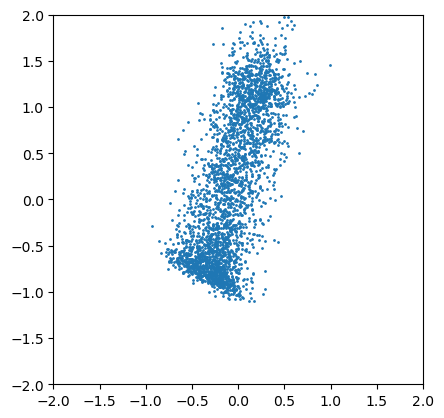

In [175]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq[-1, :, (2,9)].T, s=1)
lim=2
lims=[-lim, lim]
ax.set(xlim=lims, ylim=lims, aspect='equal')

0.7853981633974483
(3000, 10)


[(-2.0, 2.0), (-2.0, 2.0), None]

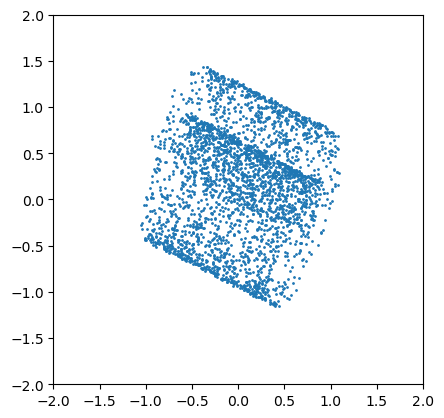

In [177]:
# original 10d dataset
print(np.pi/4)
from dataset_utils import make_nd_dataset
z, c = make_nd_dataset(num_samples, 'swiss_roll_3d', theta=np.pi/4)

print(z.shape)

fig, ax = plt.subplots(1, 1)
ax.scatter(*z[:, (2,9)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')

singular values:
 [36.173706   32.55092     1.9415739   1.6794788   1.1779219   0.47609252
  0.45756003  0.44211322  0.4397183   0.43189797]
explained var:
 [5.5047882e-01 4.4573948e-01 1.5858513e-03 1.1865981e-03 5.8369717e-04
 9.5353651e-05 8.8074623e-05 8.2228362e-05 8.1339917e-05 7.8472403e-05]
eigenvectors:
 [[-0.01003711  0.11948776 -0.35707605  0.37914371 -0.00522357 -0.09115846
   0.012753    0.14663237  0.33445114  0.7566441 ]
 [-0.06179305  0.3379675  -0.64945465  0.39962584  0.11883939 -0.09655519
  -0.11480101 -0.09630099 -0.18424468 -0.46970418]]


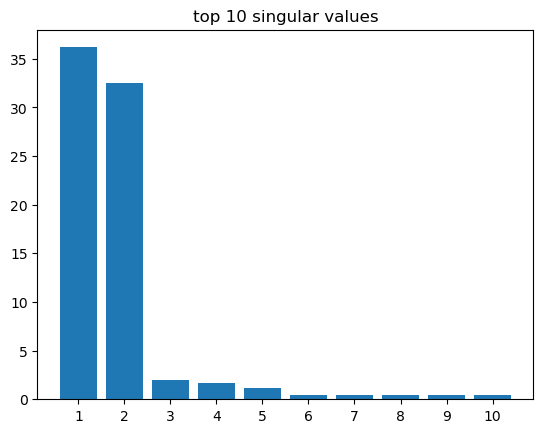

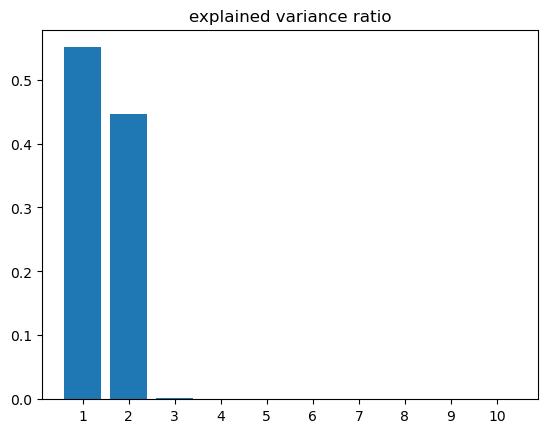

In [59]:
data_nd = x_seq[-1, :, :].detach().cpu().numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(data_nd)

# singular values
sv = pca.singular_values_
print('singular values:\n', sv)
fig, ax = plt.subplots(1, 1)
ax.bar(range(1, len(sv)+1), sv)
ax.set(title='top 10 singular values')
ax.set_xticks(np.arange(1, 11))

# explained variance ratio
evr = pca.explained_variance_ratio_
print('explained var:\n', evr)
fig, ax = plt.subplots(1, 1)
ax.bar(range(1, len(evr)+1), evr)
ax.set(title='explained variance ratio')
ax.set_xticks(np.arange(1, 11))

# principle components
comp = pca.components_
print('eigenvectors:\n', comp[:2])

projection matrix shape:
 (10, 2)
(2, 3000)


[(-2.0, 2.0), (-2.0, 2.0), None]

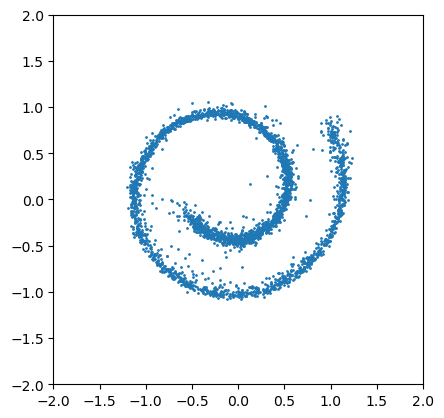

In [82]:
# project the data onto the two principle components 
# projection matrix
M = comp[:2].T
print('projection matrix shape:\n', M.shape)

data_projected = M.T@data_nd.T
# data_projected_in_10d = M@M.T@data_nd.T
print(data_projected.shape)

# now plot the projected data along the first two principle components
fig, ax = plt.subplots(1, 1)
ax.scatter(*data_projected, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')

# also plot the data manifold
